In [1]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import re
from rdkit import RDLogger
import progressbar

def clean_text(text):
    """
    Remove some part of reactions that that have the form |f:..| and is useless
    Arguments: - string (str) any
    Returns: - sring (str) without the expression |f:...|. ("..." stands for a squence of numbers
    """
    return re.sub(r'\|[^|]*\|', '', text)

def remove_atom_mapping(smiles):
    """
    Remove atom mapping numbers from a SMILES-like notation.
    Arguments:
    - smiles (str): The SMILES-like notation with atom mapping numbers.
    Returns:
    - smiles_without_mapping (str): The SMILES notation without atom mapping numbers.
    """
    pattern = r':\d+'
    smiles_without_mapping = re.sub(pattern, '', smiles)
    return smiles_without_mapping

def remove_percent_symbol(value):
    """
    Remove the '%' symbol from a percentage value.
    Arguments:
    - value (str): The percentage value with the '%' symbol.
    Returns:
    - value (str): The percentage value without the '%' symbol.
    """
    return value.replace('%', '')


# Create a Path object for the current directory
current_directory = Path.cwd()
# Creating a Path object for an example file that does not yet exist
example_file_path = current_directory / "1976_Sep2016_USPTOgrants_smiles.rsmi"

# Reading the contents of the file to test if we have well acess to our data
if example_file_path.exists():
    with example_file_path.open("r") as file:
        first_line = file.readline()
else:
    print("The file does not exist.")
print("The database is being processed. It will take a moment, please be patient.")   
with progressbar.ProgressBar(max_value=17, widgets=[progressbar.Percentage(), " ", progressbar.GranularBar()]) as bar:
    dataFrame= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
    bar.update(1)
    dataFrame = dataFrame.astype(str)
    dataFrame["ReactionSmiles"] = dataFrame["ReactionSmiles"].apply(lambda x: clean_text(x))
    bar.update(2)
#Delete columns that are not the reactions or the yield
    columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
    dataFrame.drop(columns=columns_to_delete, inplace=True)
    bar.update(3)
#Separate the Reactants from the Products
    new_columns = dataFrame['ReactionSmiles'].str.split('>', expand=True)
    new_columns = new_columns.rename(columns={0: 'Reactant 1', 2 : "Product 1"})
    bar.update(4)
    dataFrame = pd.concat([new_columns, dataFrame.iloc[:, 1:]], axis=1)
    dataFrame.drop(columns=1, inplace=True)
    bar.update(5)
#Separate the reactants from each other
    reactants_split = dataFrame['Reactant 1'].str.split("\.", expand = True)
    bar.update(6)
    reactants_split.columns = [f'Reactant {i+1}' for i in range(reactants_split.shape[1])]
    dataFrame = pd.concat([reactants_split, dataFrame.iloc[:, 1:]], axis=1)
    bar.update(7)
#Separate the Products from each other
    products_split = dataFrame['Product 1'].str.split("\.", expand = True)
    bar.update(9)
    products_split.columns = [f'Product {i+1}' for i in range(products_split.shape[1])]
    dataFrame = pd.concat([products_split, dataFrame.iloc[:, 1:]], axis=1)
    bar.update(10)
    dataFrame = dataFrame.loc[:, ~dataFrame.columns.duplicated(keep='first')]
    bar.update(11)

    dataFrame = dataFrame[dataFrame["CalculatedYield"] != 'nan']
    bar.update(12)

#Remove atom mapping
    dataFrame = dataFrame.astype(str)
    bar.update(14)
    columns_to_process = dataFrame.columns[:-1]
    bar.update(15)
    for column in columns_to_process:
        dataFrame[column] = dataFrame[column].apply(remove_atom_mapping)
        bar.update(16)
#Remove the percentage symbol from the yield's column
    dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].apply(remove_percent_symbol)
    bar.update(17)
print("Processing of the data complete!")

The database is being processed. It will take a moment, please be patient.


100% |████████████████████████████████████████████████████████████████████████|||


Processing of the data complete!


In [51]:
pd.set_option('display.max_colwidth', None)
def main():
    
    while True:
        choice=input("Press Enter to get random products or type 'exit' to quit: ")
        if choice == "exit":
            print("Exiting.")
            break
        else: 
            filtered_columns = [pd.Series(dataFrame.iloc[:, i].dropna().unique()) for i in range(53)]
            selected_columns = pd.concat(filtered_columns, axis=0)
            random_products = selected_columns.sample(n=1)
            print(random_products)

        
        choice = input("Do you want another isomer ? (yes/no): ").strip().lower()
        if choice == "no":
            print("Exiting.")
            break
            
if __name__ == "__main__":
    main()

Press Enter to get random products or type 'exit' to quit:  yes


312013    [C]1([C]2[S][CH]=[C]([Br])[N]=2)[CH]=[CH][CH]=[CH][CH]=1 
dtype: object


Do you want to continue? (yes/no):  no


Exiting.


In [9]:
# Prompt the user to enter the molecule that he wants to form
print ("you can enter the name of the molecule or its SMILES, the racemic configuration is available.")
string_input_mol = input("Enter the molecule that you want to form: ")

you can enter the name of the molecule or its SMILES, the racemic configuration is available.


Enter the molecule that you want to form:  cyanide


In [10]:
from rdkit import Chem

def is_smiles(smiles):
    """
    Check if a string represents a valid SMILES notation.
    Arguments:
    - smiles (str): The string to check.
    Returns:
    - is_valid (bool): True if the string is a valid SMILES notation, False otherwise.
    """
    if Chem.MolFromSmiles(smiles) == None:
        return False
    else:
        return True

# Check if the entered string is a valid SMILES notation
string_input_mol = remove_atom_mapping(string_input_mol)
if is_smiles(string_input_mol):
    print(f"'{string_input_mol}' is a valid SMILES notation.")
else:
    print(f"'{string_input_mol}' is not a valid SMILES notation.")

'cyanide' is not a valid SMILES notation.


[20:41:20] SMILES Parse Error: syntax error while parsing: cyanide
[20:41:20] SMILES Parse Error: Failed parsing SMILES 'cyanide' for input: 'cyanide'


In [11]:
#Convert input into SMILES if it isn't already.
import pubchempy as pcp

def name_to_smiles(molecule_name):
    """
    Convert a molecule name to a SMILES notation using PubChemPy's PubChem database.
    Arguments:
    - molecule_name (str): The name of the molecule.
    Returns:
    - smiles (str): The SMILES notation of the molecule, or None if retrieval fails.
    """
    try:
        compound = pcp.get_compounds(molecule_name, 'name')
        if compound:
            return compound[0].canonical_smiles
        else:
            print("Error: Unable to retrieve molecule information. Please try with the SMILE of the molecule")
            return None
    except:
        print("Error: Unable to retrieve molecule information. Please try again")
        return None

# Call the function to convert the molecule name to SMILES notation
if is_smiles(string_input_mol)== False:
    string_input_mol2 = string_input_mol
    string_input_mol = name_to_smiles(string_input_mol)
    if string_input_mol:
        print(f"SMILES notation for {string_input_mol2}: {string_input_mol}")
else:
    print (f"{string_input_mol} is already a SMILES notation.")

[20:41:21] SMILES Parse Error: syntax error while parsing: cyanide
[20:41:21] SMILES Parse Error: Failed parsing SMILES 'cyanide' for input: 'cyanide'


SMILES notation for cyanide: [C-]#N


In [12]:
import pandas as pd
import sys

def compare_molecule_with_data(element, string_input_mol, start_col=0, end_col=None):
    """
    Compares two strings regardless of spaces differences.
    
    Arguments:
    - two strings (str) to compare 
    - start_col (int): The starting column index for the search.
    - end_col (int): The ending column index for the search. If None, searches until the last column.
    Returns:
    - value (bool) : True if the two elements are the same, Flase otherwise.
    """
    return ''.join(element.split()).lower() == ''.join(string_input_mol.split()).lower()


def find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=None):
    """
    Search through the specified range of columns in a DataFrame for the input molecule.
    
    Arguments:
    - dataFrame (pd.DataFrame): The DataFrame to search.
    - string_input_mol (str): The molecule to search for.
    - start_col (int): The starting column index for the search.
    - end_col (int): The ending column index for the search. If None, searches until the last column.

    Returns:
    - List[int]: A list of row indices where the molecule is found.
    """
    total_elements = (end_col - start_col) * len(dataFrame)
    with progressbar.ProgressBar(max_value=total_elements, widgets=[progressbar.Percentage(), " ", progressbar.GranularBar()]) as bar:
    # Initialize a list to store the row numbers
        rows = []
    # Set end_col to the last column index if not provided
        if end_col is None:
            end_col = dataFrame.shape[1]

    # Total number of elements to check
        current_element = 0
    # Iterate over the specified range of columns in the DataFrame
        for column_name in dataFrame.columns[start_col:end_col]:
            column = dataFrame[column_name]  # Get the actual column data
            for index, value in column.items():
                if compare_molecule_with_data(value, string_input_mol):
                    rows.append(index)
                current_element += 1
                bar.update(current_element)

    return rows

print("Checking if your input is in our database")
rows = find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=53)

if rows:
    print("Row(s) where the molecule is found:", rows)
else:
    print("The product is not in the database")

  0% |                                                                        |

Checking if your input is in our database


100% |████████████████████████████████████████████████████████████████████████|||


The product is not in the database


In [13]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

def is_isomer(smiles_given):
    """
    Checks if an input has an isomer in a given dataFrame.
    
    Arguments:
    - SMILES notation of a molecule (str)
    Returns:
    - Error message (str) if input isn't a SMILES notation
    - None if no isomer found
    If found:
    - Isomer in Smiles notation (str)
    - Indexes (int) of isomer's column and row
    """
    if smiles_given is None :
        return "Invalid SMILES notation, please check input."
    else:
        mol1 = Chem.MolFromSmiles(smiles_given)
        #Give molecular formula
        formula1 = rdMolDescriptors.CalcMolFormula(mol1)
    
    for idx, row in dataFrame.iterrows():
        for col in dataFrame.columns:
            if "Product" in col:
                smiles2 = row[col]
                if smiles2 == "None":
                    continue
                else:
                    mol2 = Chem.MolFromSmiles(smiles2)
                    if mol2 is None:
                        continue
                    formula2 = rdMolDescriptors.CalcMolFormula(mol2)
                    if formula1 == formula2:
                        return smiles2, idx, col


if not rows :  
    choice = input("Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no) ")
    if choice.lower() == "no":
        print("Exiting.")
    else:
        string_input_mol3 = string_input_mol
        result = is_isomer(string_input_mol)
        if result == None:
            print ("No isomer of the input was found in the database, sorry :(.")
        else:
            string_input_mol, idx, col = result
            rows = [idx]
            print(f"The isomer found for {string_input_mol3} is {string_input_mol}, the program will continue with the latter.")



Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no)  yes


[20:44:38] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[20:44:38] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[20:44:38] Explicit valence for atom # 11 Cl, 7, is greater than permitted


The isomer found for [C-]#N is [C-]#[N], the program will continue with the latter.


In [14]:
"""
This code prints the yield and shows the image of the reaction corresponding
"""
import numpy as np
# Convert the 'Yield' column to float
dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].astype(float)
# Subset the DataFrame to include only the specified rows
subset_df = dataFrame.loc[rows]
max_yield_row_index = subset_df['CalculatedYield'].idxmax()
# Retrieve the row with the highest yield
max_yield_row = dataFrame.loc[max_yield_row_index]
mol_yield = dataFrame.loc[max_yield_row_index]["CalculatedYield"]
print(f"The reaction ha a yield of {mol_yield}%.")

# print the reaction
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
#Create a Dataframe where the reaction is in one column
dataFrameImage= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
dataFrameImage.drop(columns=columns_to_delete, inplace=True)
dataFrameImage["ReactionSmiles"] = dataFrameImage["ReactionSmiles"].apply(remove_atom_mapping)
# Create a reaction SMILES string
reaction_smiles = dataFrameImage.iloc[max_yield_row_index, 0]
# Parse the reaction SMILES string
reaction = Chem.AllChem.ReactionFromSmarts(reaction_smiles)
# Draw the reaction
reaction_image = Draw.ReactionToImage(reaction)

# Save or display the image
reaction_image.show()

The reaction ha a yield of 185.7%.


Unable to retrieve molecule name.
The Molecular weight of the product is 26.018.


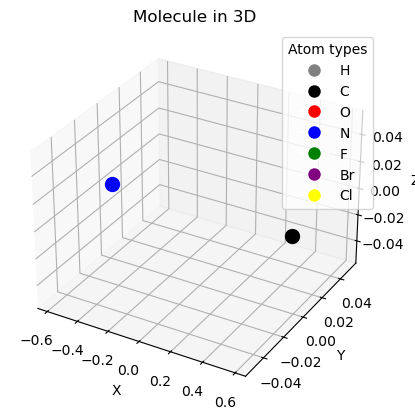

In [15]:
"Informations about the product that we want to form"

#name of the molecule

from chemspipy import ChemSpider

def get_molecule_name(smiles):
    """
    Get the common name of a molecule from its SMILES representation using ChemSpider.
    Args:
    - smiles (str): SMILES representation of the molecule.
    Returns:
    - name (str): Common name of the molecule.
    """
    cs = ChemSpider('your_api_key_here') 
    results = cs.simple_search(smiles)
    if results:
        return results[0].common_name
    else:
        return "Unable to retrieve molecule name."

print (get_molecule_name(string_input_mol))

# To print the molecular weight
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_molecular_weight(smiles):
    """
    Calculate the molecular weight of a molecule given its SMILES string.
    
    Args:
    smiles (str): SMILES string of the molecule.
    
    Returns:
    float: Molecular weight of the molecule.
    """
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    
    # Check if the molecule is valid
    if molecule is None:
        raise ValueError("Invalid SMILES string provided")
    
    # Calculate the molecular weight
    molecular_weight = Descriptors.MolWt(molecule)
    
    return molecular_weight

print (f"The Molecular weight of the product is {get_molecular_weight(string_input_mol)}.")

#3D representation of the molecule

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def plot_molecule_3D(smiles):
    """
    Plot a molecule in 3D with different colors for different types of atoms and bonds between atoms.
    Args:
    - smiles (str): SMILES representation of the molecule.
    """
    # Generate RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Error: Unable to generate molecule from SMILES.")
        return
    
    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Extract atom coordinates and symbols
    coords = mol.GetConformer().GetPositions()
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for different atom types
    atom_colors = {'H': 'gray', 'C': 'black', 'O': 'red', 'N': 'blue', 'F': 'green', 'Br': 'purple', 'Cl': 'yellow'}

    # Plot atoms with different colors
    for atom_idx, symbol in enumerate(symbols):
        x, y, z = coords[atom_idx]
        color = atom_colors.get(symbol, 'brown')  # Default to brown for unknown atoms
        ax.scatter(x, y, z, c=color, label=symbol, s=100)

    # Helper function to plot bonds
    def plot_bond(ax, start_pos, end_pos, offset=np.array([0, 0, 0])):
        ax.plot([start_pos[0] + offset[0], end_pos[0] + offset[0]], 
                [start_pos[1] + offset[1], end_pos[1] + offset[1]], 
                [start_pos[2] + offset[2], end_pos[2] + offset[2]], c='gray')

    # Plot bonds between atoms with different styles for single and double bonds
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        start_pos = coords[start_idx]
        end_pos = coords[end_idx]
        bond_type = bond.GetBondType()
        
        if bond_type == Chem.rdchem.BondType.SINGLE:
            plot_bond(ax, start_pos, end_pos)
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            # Calculate an offset direction perpendicular to the bond
            bond_vector = end_pos - start_pos
            normal_vector = np.cross(bond_vector, np.array([1, 0, 0]))
            if np.linalg.norm(normal_vector) < 1e-3:
                normal_vector = np.cross(bond_vector, np.array([0, 1, 0]))
            normal_vector /= np.linalg.norm(normal_vector)  # Normalize the vector
            offset = normal_vector * 0.125
            plot_bond(ax, start_pos, end_pos, offset)
            plot_bond(ax, start_pos, end_pos, -offset)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Molecule in 3D')

    # Show legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=symbol)
               for symbol, color in atom_colors.items()]
    ax.legend(handles=handles, title='Atom types', loc='best')

    # Show plot
    plt.show()

plot_molecule_3D(string_input_mol)
